###  Country and Position Analysis

This notebook looks at football players by their nationality and playing position. The goal is to understand which countries are strong in which positions and to compare the average market values of players from each country.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load player data
players = pd.read_csv("players.csv")

## 1. Number of Players by Country and Position

This chart shows how many players each country has in different positions.  
It helps us understand which countries produce more defenders, midfielders, attackers or goalkeepers.

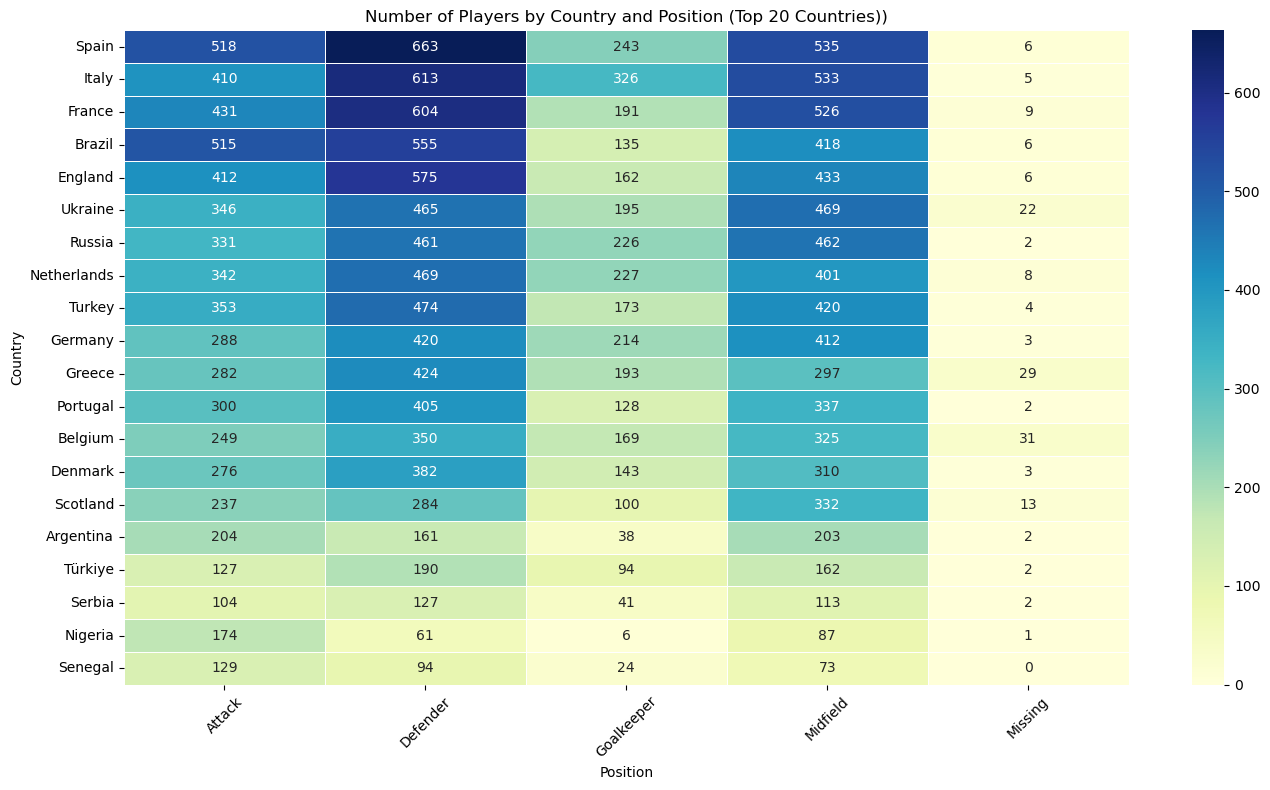

In [5]:
filtered_players = players.dropna(subset=['country_of_citizenship', 'position'])

position_matrix = (
    filtered_players
    .groupby(['country_of_citizenship', 'position'])
    .size()
    .reset_index(name='player_count')
    .pivot(index='country_of_citizenship', columns='position', values='player_count')
    .fillna(0)
    .astype(int)
)

top_countries = filtered_players['country_of_citizenship'].value_counts().head(20).index
position_matrix_top = position_matrix.loc[top_countries]

plt.figure(figsize=(14, 8))
sns.heatmap(position_matrix_top, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
plt.title("Number of Players by Country and Position (Top 20 Countries))")
plt.xlabel("Position")
plt.ylabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Average Market Value by Country and Position

This chart shows the average market value of players in each position by country.  
It helps us see which countries have more expensive players in defence, midfield, attack or goalkeeper.

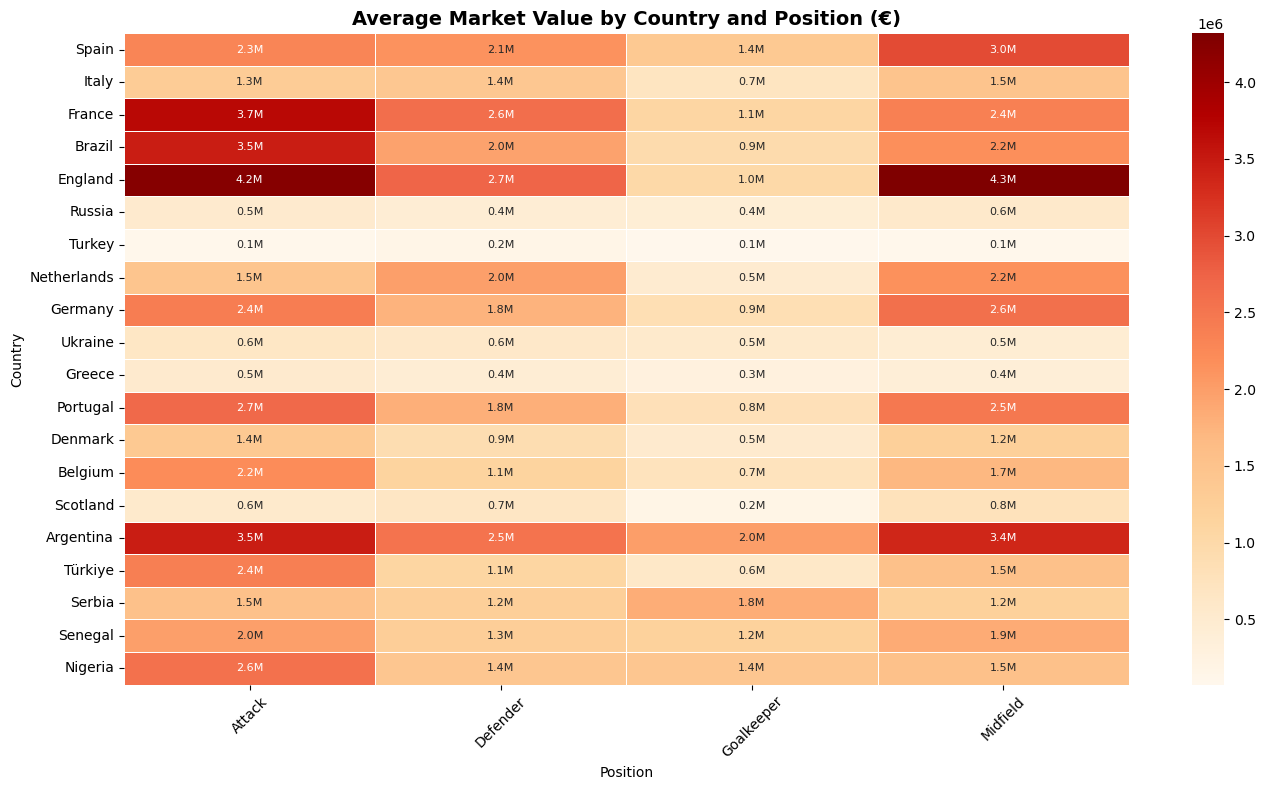

In [9]:
filtered_players = players.dropna(subset=['country_of_citizenship', 'position', 'market_value_in_eur'])
filtered_players = filtered_players[~filtered_players['position'].str.lower().str.contains('missing')]

top_countries = filtered_players['country_of_citizenship'].value_counts().head(20).index

value_matrix = (
    filtered_players
    .groupby(['country_of_citizenship', 'position'])['market_value_in_eur']
    .mean()
    .reset_index()
    .pivot(index='country_of_citizenship', columns='position', values='market_value_in_eur')
    .fillna(0)
)

value_matrix_top = value_matrix.loc[top_countries]

formatted_values = value_matrix_top.copy()
for col in formatted_values.columns:
    formatted_values[col] = formatted_values[col].map(lambda x: f'{x/1e6:.1f}M')

plt.figure(figsize=(14, 8))
sns.heatmap(
    value_matrix_top,
    annot=formatted_values,  # show millions with M
    fmt="",  # no formatting needed (already strings)
    cmap="OrRd",
    linewidths=0.5,
    annot_kws={"size": 8}
)

plt.title("Average Market Value by Country and Position (€)", fontsize=14, weight='bold')
plt.xlabel("Position")
plt.ylabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1. This shows which country has the highest average market value in each position.


Position	Top Country
Attack	England
Defender	England
Goalkeeper	Argentina
Midfield	England
England is dominant in multiple positions (Attack, Defence, Midfield). Argentina leads in Goalkeeper.



2. Each position has a global average market value.
We check how many positions each country is above this average.

Example Output:

 Spain → 4 positions above average

 France → 4 positions

 Brazil → 4 positions

 England → 4 positions

 Turkey → only 1 position above average

 Countries like Spain, France, Brazil, and England are strong across all positions.
 Countries like Turkey or Ukraine are only strong in 1–2 positions.

## 3. Player Production Trend by Position for Selected Countries

This chart shows how player production has changed over time for each position in selected countries (Brazil, Argentina, Turkey, Germany, France, and England).  
We can see which countries are consistent in producing defenders, midfielders, attackers, or goalkeepers.


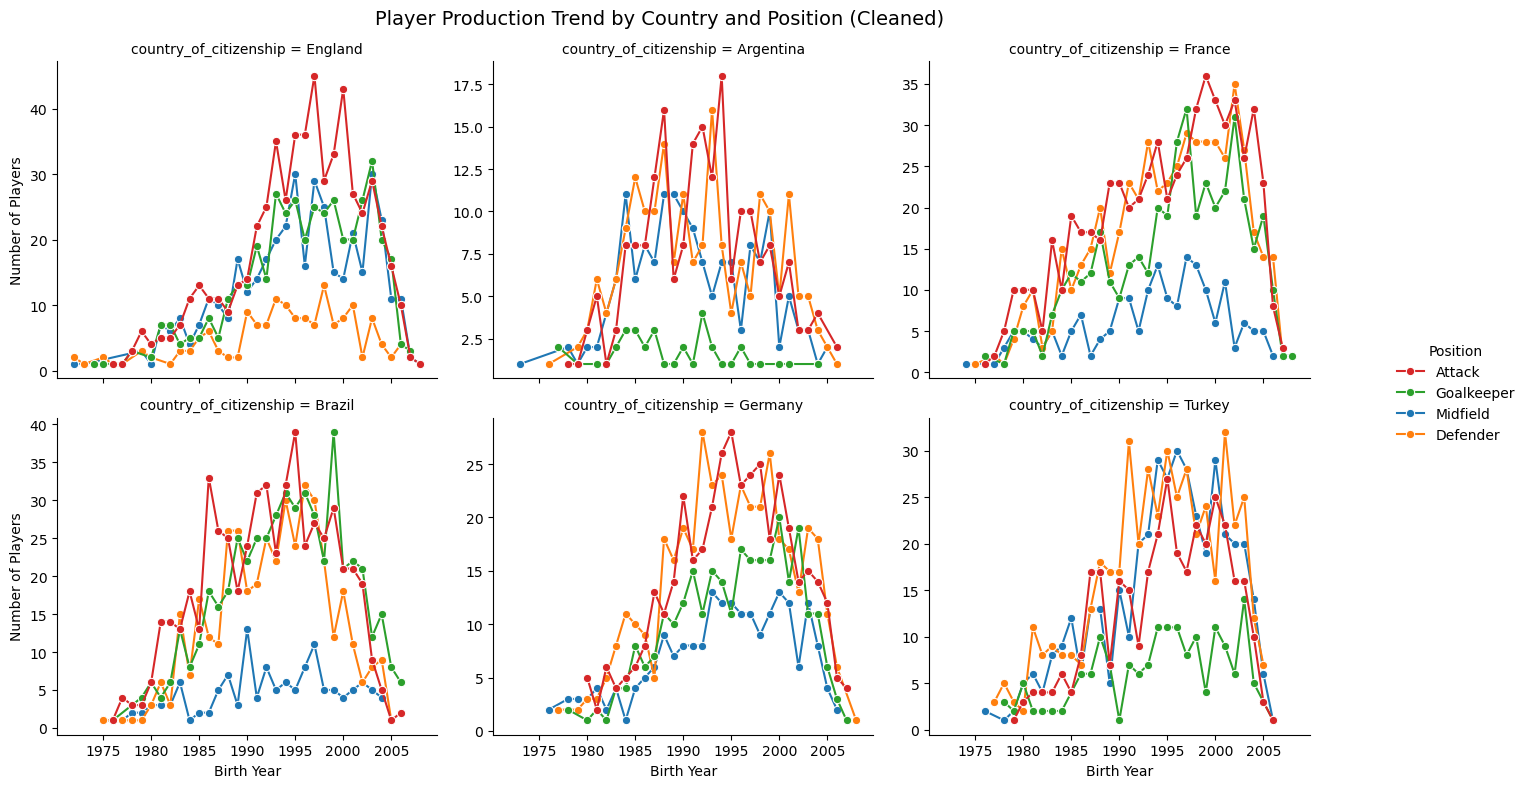

In [14]:
def is_valid_position(pos):
    if pd.isna(pos):
        return False
    pos = str(pos).strip().lower()
    return pos not in ['nan', 'none', 'missing', '', ' ']

players_cleaned = players[
    players['position'].apply(is_valid_position)
].dropna(subset=['country_of_citizenship', 'date_of_birth'])

players_cleaned['birth_year'] = pd.to_datetime(players_cleaned['date_of_birth'], errors='coerce').dt.year
players_cleaned = players_cleaned.dropna(subset=['birth_year'])

selected_countries = ['Brazil', 'Argentina', 'Turkey', 'Germany', 'France', 'England']

trend_by_country_position = (
    players_cleaned[players_cleaned['country_of_citizenship'].isin(selected_countries)]
    .groupby(['birth_year', 'country_of_citizenship', 'position'])
    .size()
    .reset_index(name='player_count')
)

g = sns.FacetGrid(trend_by_country_position, col='country_of_citizenship', col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='birth_year', y='player_count', hue='position', marker='o')
g.set_axis_labels("Birth Year", "Number of Players")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Player Production Trend by Country and Position (Cleaned)", fontsize=14)

g.add_legend(title='Position', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.tight_layout()
plt.show()


## 1-) Germany – Strong in Defence and Goalkeeper:

After 1990, Germany makes more Defenders and Goalkeepers.

Germany – Strong in Defence and Goalkeeper; low in Attack.




## 2-) Brazil – Many Attackers

Many attackers, especially after 2000.

Brazil is famous for producing skillful attackers.

## 3-) England – Midfield is Growing

After 1995, many Midfielders are born.

More playmakers and runners in midfield.



## 4-) Turkey – Unstable Production

Some years are high, others are low.

Midfield is the best position.

Goalkeeper and Attack are weak.



## 5-) France – Balanced in All Positions

All positions grow in a healthy way.

Defence and Midfield are the strongest.

## 6-) Argentina – Focus on Midfield and Attack

Many players in Midfield and Attack.

Few Goalkeepers, but steady.

## 4.  Average Market Value by Country and Position (Top 1000 Players)

This map shows the average market value (€) of the top 1000 players in each position.

It helps to see which countries produce the most valuable players for every position.

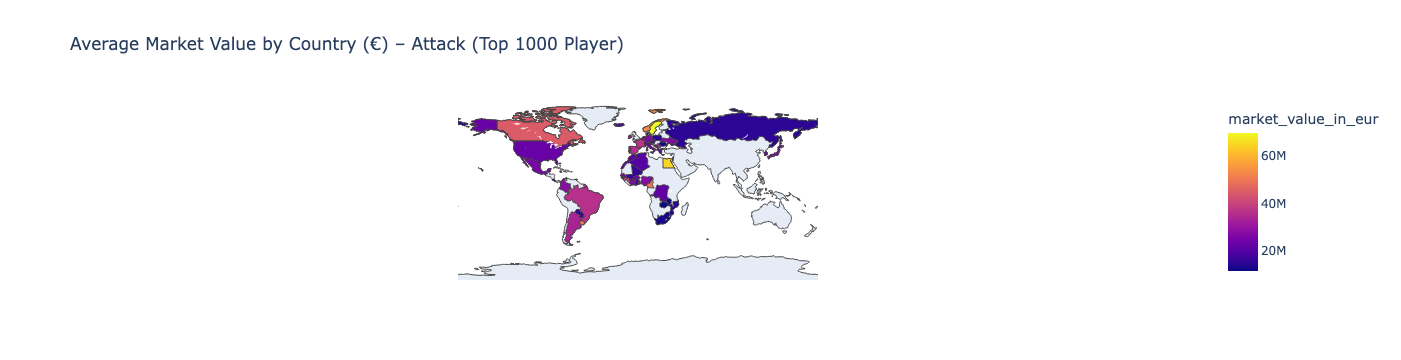

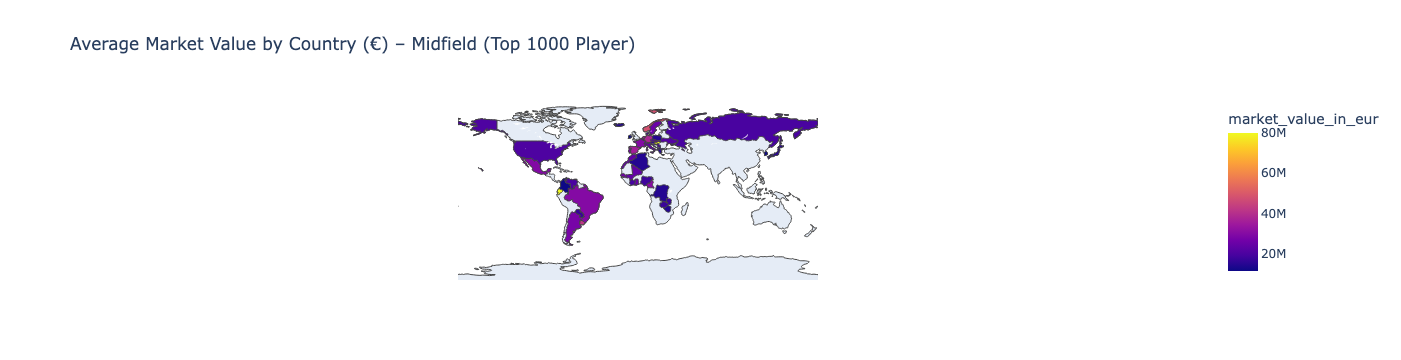

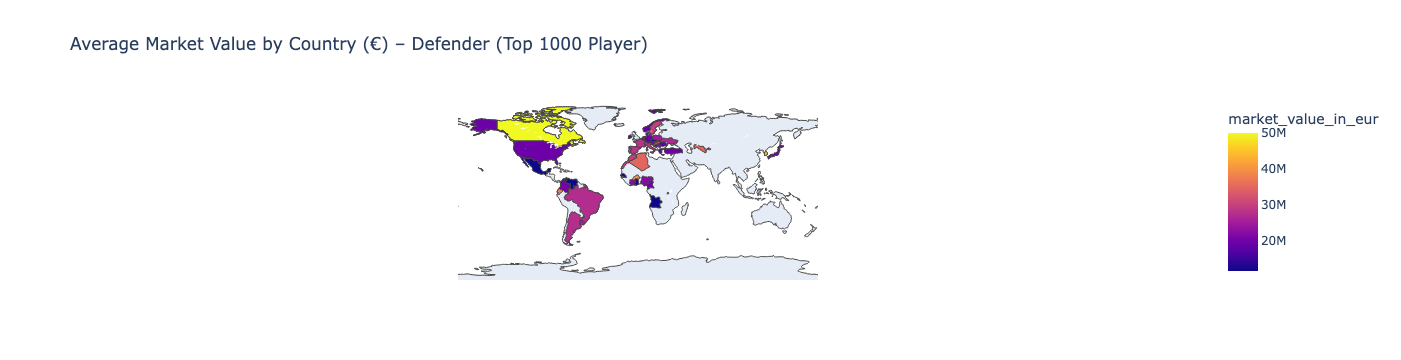

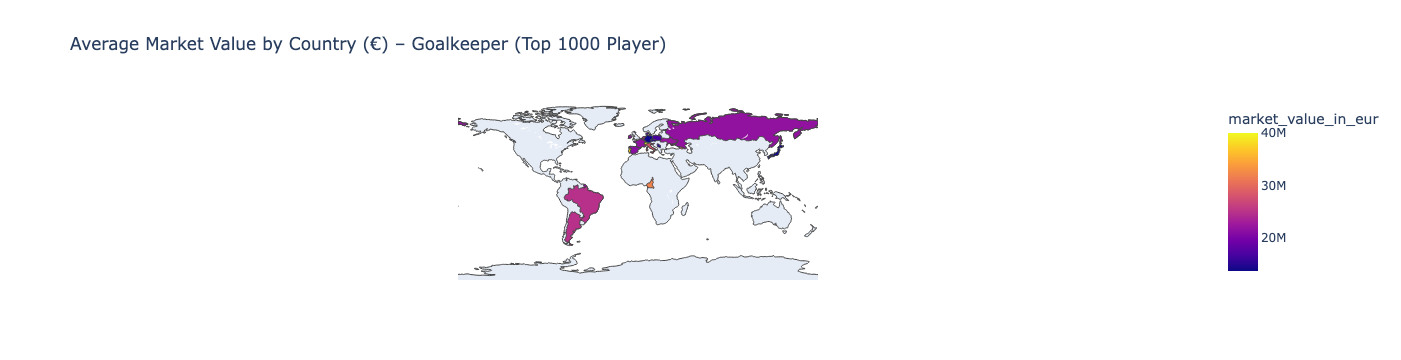

In [24]:
top_1000 = filtered_players.sort_values('market_value_in_eur', ascending=False).head(1000)

top1000_country_position_value = (
    top_1000
    .groupby(['country_of_citizenship', 'position'])['market_value_in_eur']
    .mean()
    .reset_index()
)

positions = top1000_country_position_value['position'].unique()

for pos in positions:
    pos_df = top1000_country_position_value[top1000_country_position_value['position'] == pos]
    fig = px.choropleth(
        pos_df,
        locations='country_of_citizenship',
        locationmode='country names',
        color='market_value_in_eur',
        hover_name='country_of_citizenship',
        color_continuous_scale='Plasma',
        title=f'Average Market Value by Country (€) – {pos} (Top 1000 Player)',
    )
    fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
    fig.show()


## Example Output:


Brazil, Argentina, and parts of Africa (especially Senegal) show high value.

Brazil leads in producing expensive attackers.

Midfield – Average Market Value

England, France, and Germany dominate midfield value.

European countries have strong midfield academies.

Defender – Average Market Value

France and England stand out clearly in defence value.

Defenders from top European countries are the most valuable.